# Exective summary of Work Package 2

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the classification algorithms learnt in the class, in order to achieve best F1 score.

## Tasks

- Task 1: Develop a fault detection model using the unsupervised learning algorithms learnt in the class, in order to achieve best F1 score.
- Task 2: With the help of the supporting script, develop a cross-validation scheme to test the performance of the developed classification algorithms.
- Task 3: Develop a fault detection model using the classification algorithms learnt in the class, in order to achieve best F1 score.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_2_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Unsupervised learning approaches

## Implement the statistical testing approach for fault detection

In this exercise, we interpret the statistical testing approach for fault detection. The basic idea of statistical testing approach is that we fit a multi-dimensitional distribution to the observation data under normal working condition. Then, when a new data point arrives, we design a hypothesis test to see whether the new data point is consistent with the distribution. If the new data point is consistent with the distribution, we can conclude that the fault is not due to the faulty component.

The benefit of this approach is that, to design the detection algrothim, we do not need failed data. Also, the computational time is short as all we need is just to compute the pdf and compare it to a threshold.

In this exercise, you need to:
- Fit a multi-dimensitional distribution to the training dataset (all normal samples).
- Design a fault detection algorithm based on the fitted distribution to detect faulty components.

The following block defines a few functions that you can use.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer,accuracy_score ,precision_score, recall_score
from sklearn.metrics import f1_score,confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
def estimateGaussian(X):
    '''Given X, this function estimates the parameter of a multivariate Gaussian distribution.'''
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

def classify(X, distribution, log_epsilon=-1.1e6):
    '''Given X, this function classifies each sample in X based on the multivariate Gaussian distribution. 
       The decision rule is: if the log pdf is less than log_epsilon, we predict 1, as the sample is unlikely to be from the distribution, which represents normal operation.
    '''
    p = distribution.logpdf(X)
    predictions = (p < log_epsilon).astype(int)
    
    return predictions

Let us use the dataset `20240105_164214` as training dataset, as all the samples in this dataset are normal operation. We will use the dataset `20240325_155003` as testing dataset. Let us try to predict the state of motor 1. For this, we first extract the position, temperature and voltage of motor 1 as features (you can change the features if you want). 

In [3]:
import sys
sys.path.insert(0, 'C:\\Users\lucas\Documents\GitHub\digital_twin_robot\projects\maintenance_industry_4_2024\supporting_scripts\WP_1')

from functions import *
from utility import read_all_csvs_one_test
import pandas as pd

# Specify path to the dictionary.
base_dictionary = '../../dataset/training_data/'
dictionary_name = '20240105_164214'
path = base_dictionary + dictionary_name

# Read the data.
df_data = read_all_csvs_one_test(path, dictionary_name)

# Smooth the data.
window_size = 10

smoothed_data = df_data.copy(deep=True)
smoothed_data.drop(columns=['time','test_condition'], inplace=True)

for i in range(1,7):
    smoothed_data[f'data_motor_{i}_voltage'] = smooth_data_moving_average(df_data[f'data_motor_{i}_voltage'], window_size)
    
#remove outliers

smoothed_no_outliers = remove_outliers(smoothed_data,10)

# Get the features

drop_list1_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_6_position']

drop_list2_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_6_position','data_motor_2_position','data_motor_3_position','data_motor_4_position','data_motor_5_position','data_motor_2_temperature','data_motor_3_temperature','data_motor_4_temperature','data_motor_6_temperature']

#drop_list1_label1 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_6_position']

label_columns = ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']

X_train = smoothed_no_outliers.drop(columns=label_columns+drop_list1_label1)

# Normalization
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

### We do the same to get the test dataset.

dictionary_name = '20240325_155003'
path = base_dictionary + dictionary_name

# Read the data.
df_data = read_all_csvs_one_test(path, dictionary_name)

# Smooth the data.
window_size = 10

smoothed_data = df_data.copy(deep=True)
smoothed_data.drop(columns=['time','test_condition'], inplace=True)

for i in range(1,7):
    smoothed_data[f'data_motor_{i}_voltage'] = smooth_data_moving_average(df_data[f'data_motor_{i}_voltage'], window_size)

#remove outliers

smoothed_no_outliers = remove_outliers(smoothed_data,10)

# Get the features
X_test = smoothed_no_outliers.drop(columns=label_columns+drop_list1_label1)

y_test = smoothed_no_outliers['data_motor_1_label']

# Normalization
scaler = MinMaxScaler()
X_test_normalized = scaler.fit_transform(X_test)

Please design your algorithm below:

In [4]:
# First, we need to fit a MVN distribution to the normal samples.
# Put your code here.

mu, sigma2 = estimateGaussian(pd.DataFrame(X_train))

variances = sigma2.values  # Convert sigma2 to a numpy array
variances_1d = np.diag(variances)  # Create a diagonal matrix using variances

# Add a small epsilon value to ensure positive definiteness
epsilon = 1e-1
sigma2_reg = variances_1d + epsilon * np.eye(len(variances_1d))

# Construct multivariate Gaussian distribution
distribution = multivariate_normal(mean=mu, cov=sigma2_reg)

# Construct a multivariate Gaussian distribution to represent normal operation.
#distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))

y_pred = classify(X_test,distribution)

# Calculate accuracy of the prediction.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8618773157678057


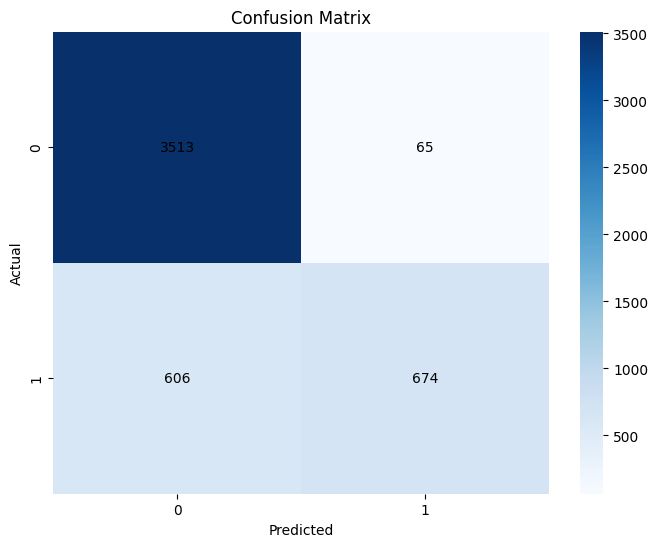

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3578
           1       0.91      0.53      0.67      1280

    accuracy                           0.86      4858
   macro avg       0.88      0.75      0.79      4858
weighted avg       0.87      0.86      0.85      4858



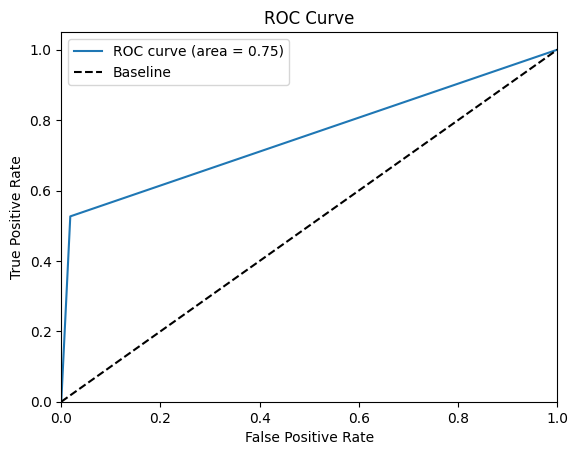

In [5]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i][j]), ha='center', va='center')

sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Discussions:**
- Can you please try to improve the performance of this approach?
    - For example, by normalizating the data?
    - By smoothing the data?
    - By reducing feature number?
    - etc.
- The parameter log_epsilon defines the threshold we use for making classification. What happens if you change it?
- Could you discuss how we should get the best value for this parameter?

- For values greater than or equal to log_epsilon=-1e6, the model's accuracy remains unchanged. However, for log_epsilon values greater than -2e6, we observe a significant increase in false negatives and the model performs similar to a random classifier (area under the ROC curve = 0.5). When log_epsilon is set to values lower than -1e6, the accuracy of the model begins to decrease considerably.

- no improvement by reducing the number of features

- no improvement by normalizating


## Local outiler factor (LOF)

The local outlier factor (LOF) algorithm computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. You can easiliy implement LOF in scikit-learn ([tutorial](https://www.datatechnotes.com/2020/04/anomaly-detection-with-local-outlier-factor-in-python.html)).

Please implement local outlier factor (LOF) algorithm on the dataset of `20240325_155003`. You can try first to detect the failure of motor 1 using this model. Please calculate the accuracy score of your prediction.

In [6]:
lof = LocalOutlierFactor(n_neighbors=550, contamination=.05)
y_pred = lof.fit_predict(X_test)

# Convert predicted labels (-1 and 1) to match class labels (0 and 1)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Calculate accuracy of the prediction.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7593659942363112


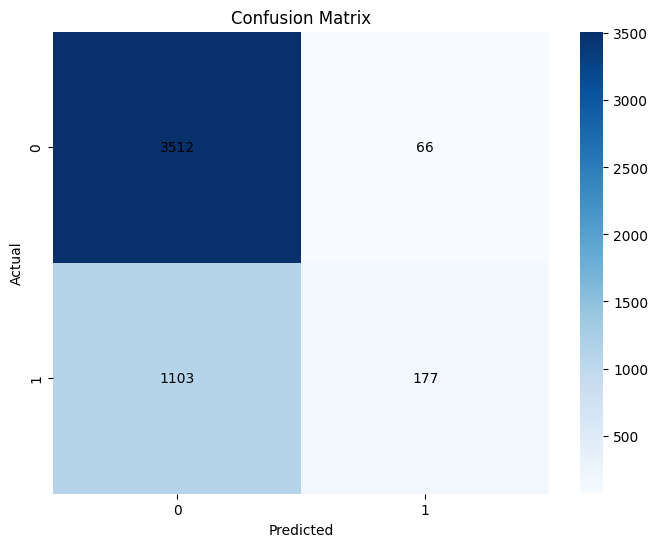

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      3578
           1       0.73      0.14      0.23      1280

    accuracy                           0.76      4858
   macro avg       0.74      0.56      0.54      4858
weighted avg       0.75      0.76      0.69      4858



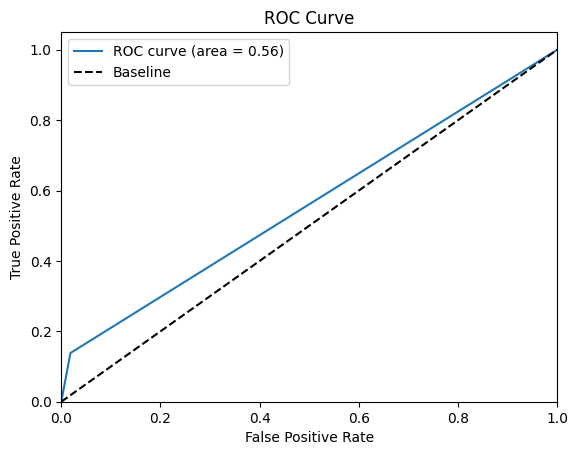

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i][j]), ha='center', va='center')

sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
import sys
sys.path.insert(0, 'C:\\Users\lucas\Documents\GitHub\digital_twin_robot\projects\maintenance_industry_4_2024\supporting_scripts\WP_1')

from functions import *
from utility import read_all_test_data_from_path

# Specify path to the dictionary.
# Define the path to the folder 'collected_data'
base_dictionary = '../../dataset/training_data/'
# Read all the data
df_data = read_all_test_data_from_path(base_dictionary, is_plot = False)

# Task 2 Develop a cross validation pipeline to evaluate the performance of the model.

The idea of cross validation is to split the data into k subsets and use one of them as the test set and the rest as the training set. The performance of the model is evaluated only on the test dataset, while the model is trained on the training dataset. By doing this, we ensure that the evaluation of the model is independent from the training of the model. Therefore, we can detect if the model is overfitted.

## k-fold cross validation

Here, we use motor 1 as an example to develop a pipeline for cross validation. Below, you have a script that read the data, extract features and get the labels.

1. Use sk-learn to split the data into training and testing sets, using a k-fold cross validation with k=5. (Hint: This is a routine task which can be answered easily by language models like chatgpt. You can try prompt like this: `Generate a code in python to split the data X and y into training and testing sets, using a k-fold cross validation with k=5.`)
2. Then, train a basic logistic regression model, without hyper-parameter tuning on the training set, and use the testing set to evaluate the performance of the model (calculate accuracy, precision, recall, and F1 score). 
3. Finally, train a logistic regression model, but use the entire dataset X and y as training data. Then, use the trained model to predict the labels of the same dataset (X). Compare the results with the previous step, and discuss why we should use cross validation to evaluate the performance of the model.

1

In [9]:
# Smooth the data.
window_size = 10

smoothed_data = df_data.copy(deep=True)
smoothed_data.drop(columns=['time','test_condition'], inplace=True)

for i in range(1,7):
    smoothed_data[f'data_motor_{i}_voltage'] = smooth_data_moving_average(df_data[f'data_motor_{i}_voltage'], window_size)
    
#remove outliers-

smoothed_no_outliers = remove_outliers(smoothed_data,10)

# Get the features

drop_list1_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_6_position']

drop_list2_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_6_position','data_motor_2_position','data_motor_3_position','data_motor_4_position','data_motor_5_position','data_motor_2_temperature','data_motor_3_temperature','data_motor_4_temperature','data_motor_6_temperature']

#drop_list1_label1 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_6_position']

label_columns = ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']

X = smoothed_no_outliers.drop(columns=label_columns+drop_list1_label1)

y = smoothed_no_outliers['data_motor_1_label']

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train_unsampled, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_unsampled, y_test = y.iloc[train_index], y.iloc[test_index]
    
    ## undersampling 
    
    # Class count
    count_class_0, count_class_1 = y_train_unsampled.value_counts()

    # Separate majority and minority classes
    data_Normal = X_train_unsampled[y_train_unsampled == 0]
    data_Failure = X_train_unsampled[y_train_unsampled == 1]

    # Undersample majority class
    data_Normal_under = data_Normal.sample(count_class_1)
    data_under = pd.concat([data_Normal_under, data_Failure], axis=0)
    
    undersampled_indices = data_under.index

    X_train = X_train_unsampled.loc[undersampled_indices]
    y_train = y_train_unsampled.loc[undersampled_indices]


2

Cross-validation scores: [0.9857894  0.98777715 0.9886299  0.98848778 0.98763502]
Mean accuracy: 0.9876638490790537


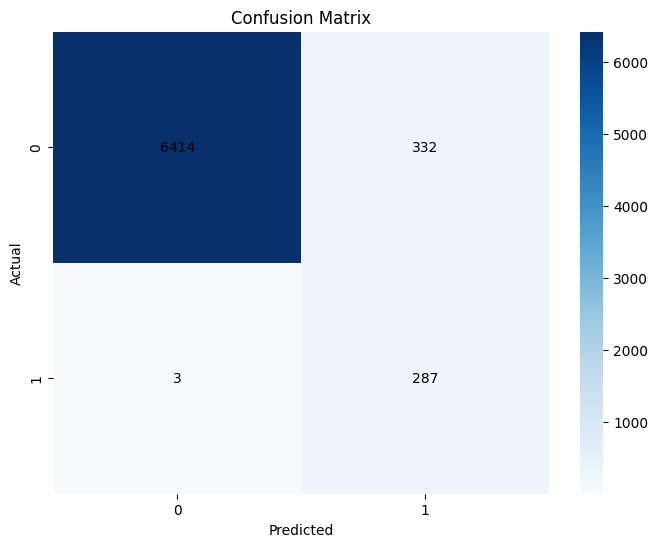

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6746
           1       0.46      0.99      0.63       290

    accuracy                           0.95      7036
   macro avg       0.73      0.97      0.80      7036
weighted avg       0.98      0.95      0.96      7036



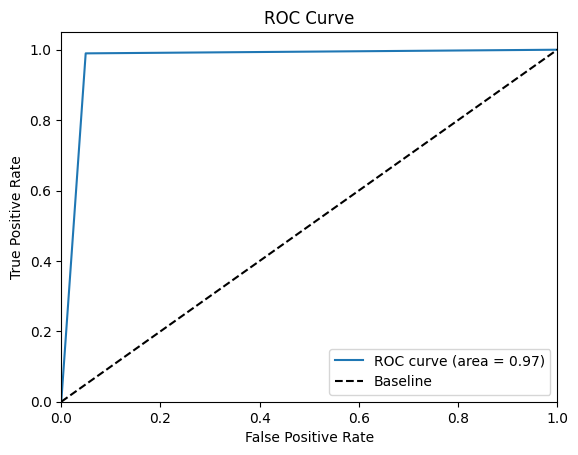

In [10]:
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize logistic regression model with a higher max_iter value
log_reg_model = LogisticRegression(max_iter=1000)

# Initialize logistic regression model
#log_reg_model = LogisticRegression()

# Perform cross-validation
cv_scores = cross_val_score(log_reg_model, X, y, cv=kf)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Train the logistic regression model on the training data
log_reg_model.fit(X_train, y_train)

# Predict labels for the test data
y_pred = log_reg_model.predict(X_test)

# Calculate evaluation metrics
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i][j]), ha='center', va='center')

sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

3

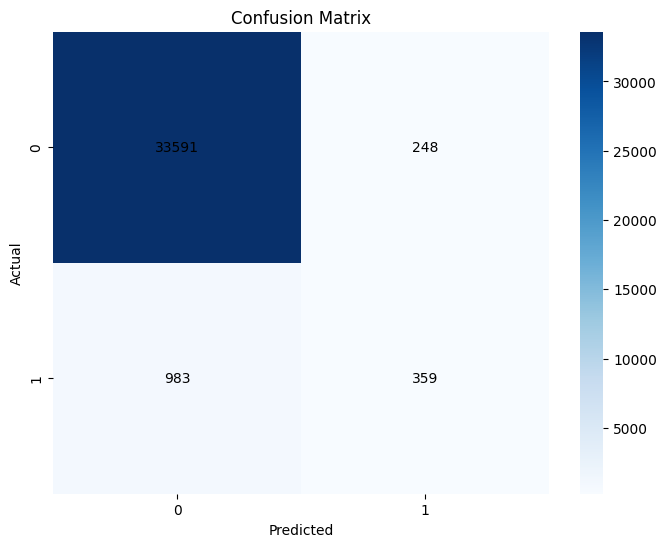

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     33839
           1       0.59      0.27      0.37      1342

    accuracy                           0.97     35181
   macro avg       0.78      0.63      0.68     35181
weighted avg       0.96      0.97      0.96     35181



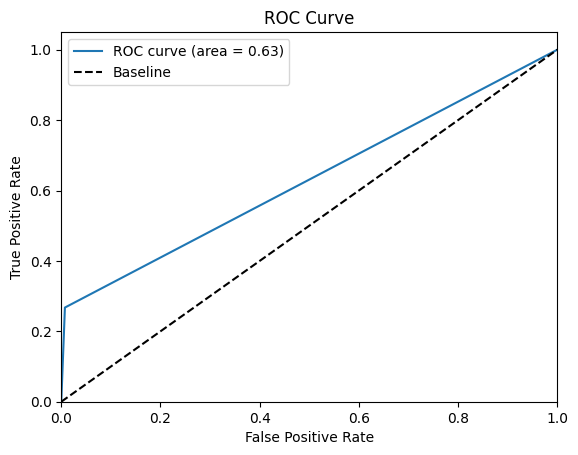

In [11]:
# Train a logistic regression model on the entire dataset
log_reg_model_full = LogisticRegression()
log_reg_model_full.fit(X, y)

# Predict labels for the entire dataset
y_pred_full = log_reg_model_full.predict(X)

# Calculate evaluation metrics
cm = confusion_matrix(y, y_pred_full)

plt.figure(figsize=(8, 6))

for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i][j]), ha='center', va='center')

sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y, y_pred_full))

fpr, tpr, thresholds = roc_curve(y, y_pred_full) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Write your discussions here:


not splitting the data can lead to overly optimistic performance estimates, as the model may inadvertently memorize the training data, making it less reliable when applied to new, unseen instances.

# Task 3: Develop classification-based fault detection models

In this task, you are supposed to experiment different classification-based fault detection models to get best F1 score. Please use the 5-fold cross-validation to calculate the best F1 score. You are free to try different models, whether they are discussed in the class or not. To simply your work, you can use the models existed in [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html).

Please report all the models you tried, how to you tune their hyperparameters, and the corresponding F1 score. Please note that if you would like to tune the hyperparameter, you can use the `GridSearchCv` function in scikit-learn, but you should use it only on the training dataset.

## Logistic regression

In [12]:
# Your code here:

In [13]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Dictionary to store model performance metrics
model_metrics = {}

# Define hyperparameter grids
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}
}

# Perform cross-validation, hyperparameter tuning, and evaluation
for model_name, model in models.items():
    
    # Hyperparameter tuning
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store metrics in the dictionary
    model_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got, its performance, and how could you further improve it.

| Model                    | Accuracy | Precision | Recall | F1    |
|--------------------------|----------|-----------|--------|-------|
| Logistic Regression       | 90.52%   | 30.26%   | 99.66%  | 46.43% |
| Decision Tree             | 99.52%   | 89.51%   | 100.00%  | 94.46% |
| Random Forest             | 99.53%   | 89.78%   | 100.00%  | 94.62% |
| Support Vector Machine    | 78.70%   | 14.25%   | 83.10%  | 24.33% |
| Gradient Boosting         | 99.63%   | 92.04%   | 99.66%  | 95.70% |



In [14]:
# Update the summary table with the model performance metrics
summary_table = "| Model                    | Accuracy | Precision | Recall | F1    |\n"
summary_table += "|--------------------------|----------|-----------|--------|-------|\n"
for model_name, metrics in model_metrics.items():
    summary_table += f"| {model_name:25} | {metrics['Accuracy']*100:.2f}%   | {metrics['Precision']*100:.2f}%   | {metrics['Recall']*100:.2f}%  | {metrics['F1']*100:.2f}% |\n"

print(summary_table)

| Model                    | Accuracy | Precision | Recall | F1    |
|--------------------------|----------|-----------|--------|-------|
| Logistic Regression       | 90.52%   | 30.26%   | 99.66%  | 46.43% |
| Decision Tree             | 99.52%   | 89.51%   | 100.00%  | 94.46% |
| Random Forest             | 99.53%   | 89.78%   | 100.00%  | 94.62% |
| Support Vector Machine    | 78.70%   | 14.25%   | 83.10%  | 24.33% |
| Gradient Boosting         | 99.63%   | 92.04%   | 99.66%  | 95.70% |



### Use the demo_motor_6 to avoid have the same sequence in the train and in the test (There will be another table summarizing the results using demo 6 at the end)

In [ ]:
n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    remove_outliers(df)
    cal_diff(df, n_int)
    
# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [41]:
# Ignore warnings.
warnings.filterwarnings('ignore')

logistic_steps = [
    ('Normalizer', MinMaxScaler()),
    ('mdl', LogisticRegression(class_weight='balanced'))
]
logistic_pipeline = Pipeline(logistic_steps)
logistic_param_grid = {
    'mdl__C': [0.01, 0.1, 1, 10]
}

tree_pipeline = Pipeline([
    ('mdl', DecisionTreeClassifier(class_weight='balanced'))
])
tree_param_grid = {
    'mdl__max_depth': [10, 20, 30],
    'mdl__min_samples_split': [2, 10]
}

svm_steps = [
    ('Normalizer', MinMaxScaler()),
    ('mdl', SVC(class_weight='balanced'))
]
svm_pipeline = Pipeline(svm_steps)

gb_pipeline = Pipeline([
    ('mdl', GradientBoostingClassifier())
])
gb_param_grid = {
    'mdl__n_estimators': [25,50],
    'mdl__learning_rate': [0.1,1],
    'mdl__max_depth': [5,7]
}

# Initialize GridSearchCV for each model
models = [
    ('Logistic Regression', logistic_pipeline, logistic_param_grid),
    ('Decision Tree', tree_pipeline, tree_param_grid),
    ('Support Vector Machine', svm_pipeline, {}),
    ('Gradient Boosting', gb_pipeline, gb_param_grid)
]

In [36]:
from utility2 import run_cv_one_motor

# Smooth the data.

smoothed_data = df_data.copy(deep=True)

for i in range(1,7):
    smoothed_data[f'data_motor_{i}_voltage'] = smooth_data_moving_average(smoothed_data[f'data_motor_{i}_voltage'],10)

# Specify the test conditions you would like to include in the test.
df_data_experiment = smoothed_data[smoothed_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
# We want a five-fold cross validation.
n_cv = 7
# Define the features. The features were chosen based on the violin plot
feature_list_selected = ['time','data_motor_1_position',  'data_motor_1_temperature', 
                    'data_motor_2_position',  
                    'data_motor_3_position',  
                    'data_motor_4_position', 'data_motor_4_temperature',
                    'data_motor_5_position', 'data_motor_5_temperature',
                    'data_motor_6_position', 'data_motor_6_temperature', 
                    'data_motor_1_position_diff', 'data_motor_1_temperature_diff', 
                    'data_motor_2_position_diff',  
                    'data_motor_3_position_diff',  
                    'data_motor_4_position_diff', 'data_motor_4_temperature_diff', 
                    'data_motor_5_position_diff', 'data_motor_5_temperature_diff', 
                    'data_motor_6_position_diff', 'data_motor_6_temperature_diff',
                    'data_motor_1_voltage','data_motor_2_voltage','data_motor_3_voltage','data_motor_5_voltage',
                    'data_motor_1_voltage_diff','data_motor_2_voltage_diff','data_motor_3_voltage_diff','data_motor_5_voltage_diff','data_motor_6_voltage_diff']
window_size = 100
sample_step = 50

In [37]:
results = {}
final_results = []
best_params = {}

for model_name, pipeline, param_grid in models:
    print(f'Running model: {model_name}')
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
    df_perf = run_cv_one_motor(
        motor_idx=6, df_data=df_data_experiment, mdl=grid_search, 
        feature_list=feature_list_selected, n_fold=n_cv, 
        window_size=window_size, sample_step=sample_step, 
        single_run_result=False
    )
    results[model_name] = df_perf
    
    # Store the mean performance in the final results
    final_results.append({
        'Model': model_name,
        **{f'Mean {col}': df_perf[col].mean() for col in df_perf.columns}
    })
    
    if param_grid:  # Save best parameters only if there was a grid search
        best_params[model_name] = grid_search.best_params_

Running model: Logistic Regression
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.285213   0.047227  0.342488  0.083007
1  0.681818   0.704082  0.841463  0.766667
2  0.900217   1.000000  0.643411  0.783019
3  0.916402   0.000000  0.000000  0.000000
4  0.557143   0.410334  0.778098  0.537313
5  0.936000   0.960905  0.972917  0.966874
6  0.467552   0.333333  0.702830  0.452200


Mean performance metric and standard error:
Accuracy: 0.6778 +- 0.2536
Precision: 0.4937 +- 0.4071
Recall: 0.6116 +- 0.3334
F1 score: 0.5127 +- 0.3641


Running model: Decision Tree
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.424233   0.005643  0.029079  0.009451
1  0.378788   0.000000  0.000000  0.000000
2  0.720174   0.000000  0.000000  0.000000
3  0.933333   0.000000  0.000000  0.000000
4  0.736190   0.690217  0.365994  0.478343
5  0.650000   0.944606  0.675000  0.787363
6  0.687316   0.000000  0.000000  0.000000


Mean performance metric and standard error:
Accuracy:

In [40]:
df_final_results = pd.DataFrame(final_results)
df_final_results


,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1 score
0,Logistic Regression,0.677764,0.493697,0.611601,0.512726
1,Decision Tree,0.647148,0.234352,0.152868,0.182165
2,Support Vector Machine,0.806733,0.678529,0.505786,0.498677
3,Gradient Boosting,0.706771,0.475126,0.292737,0.319107


In [39]:
grid_search.best_params_

{'mdl__learning_rate': 0.1, 'mdl__max_depth': 5, 'mdl__n_estimators': 50}

The support vector machine was the model with the best result. Now let's split up the operations: 

# Seperate operation mode

In [17]:
from utility2 import run_cv_one_motor


# Define a function to run experiment.
def run_experiment(motor_id, df_data, mdl, window_size=1, sample_step=1, n_fold=5):
    print(f'window_size={window_size}, sample_step={sample_step}, all the features.')
    feature_list_all = ['time','data_motor_1_position',  'data_motor_1_temperature', 
                    'data_motor_2_position',  
                    'data_motor_3_position',  
                    'data_motor_4_position', 'data_motor_4_temperature',
                    'data_motor_5_position', 'data_motor_5_temperature',
                    'data_motor_6_position', 'data_motor_6_temperature', 
                    'data_motor_1_position_diff', 'data_motor_1_temperature_diff', 
                    'data_motor_2_position_diff',  
                    'data_motor_3_position_diff',  
                    'data_motor_4_position_diff', 'data_motor_4_temperature_diff', 
                    'data_motor_5_position_diff', 'data_motor_5_temperature_diff', 
                    'data_motor_6_position_diff', 'data_motor_6_temperature_diff',
                    'data_motor_1_voltage','data_motor_2_voltage','data_motor_3_voltage','data_motor_5_voltage',
                    'data_motor_1_voltage_diff','data_motor_2_voltage_diff','data_motor_3_voltage_diff','data_motor_5_voltage_diff','data_motor_6_voltage_diff']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_all, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

    print(f'window_size={window_size}, sample_step={sample_step}, randomly pick features.')
    feature_list_self = ['time', 'data_motor_6_position', 'data_motor_6_temperature', 
                        'data_motor_5_position', 'data_motor_4_position', 'data_motor_3_position', 'data_motor_2_position', 'data_motor_1_position']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_self, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

## Not moving

In [43]:
# Not moving
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055'])]
n_cv = 3

Windowsize = 1.

In [46]:
print("---------------Running experiments for Logistic Regression:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=logistic_pipeline, n_fold=n_cv)

print("---------------Running experiments for Decision Tree:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=tree_pipeline, n_fold=n_cv)

print("---------------Running experiments for Support Vector Machine:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=svm_pipeline, n_fold=n_cv)

---------------Running experiments for Logistic Regression:---------------
window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.939394   0.935897  0.890244  0.912500
1  0.885714   0.773109  0.713178  0.741935
2  0.060345   0.060345  1.000000  0.113821


Mean performance metric and standard error:
Accuracy: 0.6285 +- 0.4928
Precision: 0.5898 +- 0.4657
Recall: 0.8678 +- 0.1447
F1 score: 0.5894 +- 0.4206


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.948052   0.960526  0.890244  0.924051
1  0.896429   0.814159  0.713178  0.760331
2  0.060345   0.060345  1.000000  0.113821


Mean performance metric and standard error:
Accuracy: 0.6349 +- 0.4983
Precision: 0.6117 +- 0.4830
Recall: 0.8678 +- 0.1447
F1 score: 0.5994 +- 0.4284


---------------Running experiments for Decision Tree:---------------
window_size=1, sample_step=1, all the features.
Model for moto

Windowsize = 50.

In [49]:
# Windowsize = 50.
window_size = 50
sample_step = 10

print("---------------Running experiments for Logistic Regression:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=logistic_pipeline, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

print("---------------Running experiments for Decision Tree:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=tree_pipeline, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

print("---------------Running experiments for Support Vector Machine:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=svm_pipeline, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

---------------Running experiments for Logistic Regression:---------------
window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.824176   0.727273  0.975610  0.833333
1  0.884540   1.000000  0.542636  0.703518
2  0.063317   0.063317  1.000000  0.119093


Mean performance metric and standard error:
Accuracy: 0.5907 +- 0.4577
Precision: 0.5969 +- 0.4818
Recall: 0.8394 +- 0.2573
F1 score: 0.5520 +- 0.3805


window_size=50, sample_step=10, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.873626   0.792079  0.975610  0.874317
1  0.921722   1.000000  0.689922  0.816514
2  0.063317   0.063317  1.000000  0.119093


Mean performance metric and standard error:
Accuracy: 0.6196 +- 0.4823
Precision: 0.6185 +- 0.4919
Recall: 0.8885 +- 0.1724
F1 score: 0.6033 +- 0.4203


---------------Running experiments for Decision Tree:---------------
window_size=50, sample_step=10, all the features.
Model fo

| Model                 | Configuration | Features Used | Accuracy | Precision | Recall | F1 Score |
|-----------------------|---------------|---------------|----------|-----------|--------|----------|
| Logistic Regression   | Window: 1, Sample: 1  | All           | 0.6285   | 0.5898    | 0.8678 | 0.5894   |
| Logistic Regression   | Window: 1, Sample: 1  | Random        | 0.6349   | 0.6117    | 0.8678 | 0.5994   |
| Logistic Regression   | Window: 50, Sample: 10 | All           | 0.5907   | 0.5969    | 0.8394 | 0.5520   |
| Logistic Regression   | Window: 50, Sample: 10 | Random        | 0.6196   | 0.6185    | 0.8885 | 0.6033   |
| Decision Tree         | Window: 1, Sample: 1  | All           | 0.9543   | 1.0000    | 0.7119 | 0.8242   |
| Decision Tree         | Window: 1, Sample: 1  | Random        | 0.9543   | 1.0000    | 0.7119 | 0.8242   |
| Decision Tree         | Window: 50, Sample: 10 | All           | 0.9303   | 0.8699    | 0.8665 | 0.8629   |
| Decision Tree         | Window: 50, Sample: 10 | Random        | 0.9173   | 0.8392    | 0.8515 | 0.8389   |
| Support Vector Machine| Window: 1, Sample: 1  | All           | 0.9033   | 0.5827    | 0.4694 | 0.5168   |
| Support Vector Machine| Window: 1, Sample: 1  | Random        | 0.9056   | 0.6667    | 0.4210 | 0.5151   |
| Support Vector Machine| Window: 50, Sample: 10 | All           | 0.8833   | 0.5974    | 0.4467 | 0.4695   |
| Support Vector Machine| Window: 50, Sample: 10 | Random        | 0.8976   | 0.5543    | 0.5345 | 0.5347   |

## Move only motor 6. (Only logistic regression gave satisfactory results, we can try changing the features too)

Windowsize = 1

In [52]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_164675', '20240503_165189'])]
n_cv = 2

print("---------------Running experiments for Logistic Regression:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=logistic_pipeline, n_fold=n_cv)

---------------Running experiments for Logistic Regression:---------------
window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.801336   0.801336     1.0  0.889713
1  0.272844   0.272844     1.0  0.428716


Mean performance metric and standard error:
Accuracy: 0.5371 +- 0.3737
Precision: 0.5371 +- 0.3737
Recall: 1.0000 +- 0.0000
F1 score: 0.6592 +- 0.3260


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.801336   0.801336  1.000000  0.889713
1  0.447876   0.312608  0.853774  0.457649


Mean performance metric and standard error:
Accuracy: 0.6246 +- 0.2499
Precision: 0.5570 +- 0.3456
Recall: 0.9269 +- 0.1034
F1 score: 0.6737 +- 0.3055




Windowsize = 5.

In [57]:
# Windowsize = 5.
window_size = 5
sample_step = 10

print("---------------Running experiments for Logistic Regression:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=logistic_pipeline, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

---------------Running experiments for Logistic Regression:---------------
window_size=5, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.806723   0.806723     1.0  0.893023
1  0.274256   0.274256     1.0  0.430457


Mean performance metric and standard error:
Accuracy: 0.5405 +- 0.3765
Precision: 0.5405 +- 0.3765
Recall: 1.0000 +- 0.0000
F1 score: 0.6617 +- 0.3271


window_size=5, sample_step=10, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.806723   0.806723  1.000000  0.893023
1  0.587322   0.383442  0.830189  0.524590


Mean performance metric and standard error:
Accuracy: 0.6970 +- 0.1551
Precision: 0.5951 +- 0.2993
Recall: 0.9151 +- 0.1201
F1 score: 0.7088 +- 0.2605




## Pick up and place (Only logistic regression gave satisfactory results, we can try changing the features too)

Windowsize = 1

In [59]:
# Pick up and place
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_163963', '20240325_155003'])]
n_cv = 2

print("---------------Running experiments for Logistic Regression:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=logistic_pipeline, n_fold=n_cv)

print("---------------Running experiments for Decision Tree:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=tree_pipeline, n_fold=n_cv)

print("---------------Running experiments for Support Vector Machine:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=svm_pipeline, n_fold=n_cv)

---------------Running experiments for Logistic Regression:---------------
window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.768491   0.139953  0.289176  0.188620
1  0.302002   0.302002  1.000000  0.463904


Mean performance metric and standard error:
Accuracy: 0.5352 +- 0.3299
Precision: 0.2210 +- 0.1146
Recall: 0.6446 +- 0.5026
F1 score: 0.3263 +- 0.1947


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.840649   0.223338  0.287561  0.251412
1  0.302002   0.302002  1.000000  0.463904


Mean performance metric and standard error:
Accuracy: 0.5713 +- 0.3809
Precision: 0.2627 +- 0.0556
Recall: 0.6438 +- 0.5038
F1 score: 0.3577 +- 0.1503


---------------Running experiments for Decision Tree:---------------
window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093205   0.093069     1.0  0.170289

Windowsize = 50

In [63]:
# Windowsize = 50.
window_size = 50
sample_step = 10

print("---------------Running experiments for Logistic Regression:---------------")
run_experiment(motor_id=6, df_data=df_data_mode, mdl=logistic_pipeline, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

---------------Running experiments for Logistic Regression:---------------
window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.432985   0.074830  0.444265  0.128086
1  0.315455   0.315455  1.000000  0.479613


Mean performance metric and standard error:
Accuracy: 0.3742 +- 0.0831
Precision: 0.1951 +- 0.1701
Recall: 0.7221 +- 0.3930
F1 score: 0.3038 +- 0.2486


window_size=50, sample_step=10, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.616084   0.105761  0.415186  0.168580
1  0.315455   0.315455  1.000000  0.479613


Mean performance metric and standard error:
Accuracy: 0.4658 +- 0.2126
Precision: 0.2106 +- 0.1483
Recall: 0.7076 +- 0.4135
F1 score: 0.3241 +- 0.2199


